In [1]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import pytz

import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from spacepy import pycdf

from utils.download_data import download_themis_data
from utils.plot_data import *
from utils.process_data import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# base_url = "https://themis.ssl.berkeley.edu/data/themis/tha/l2/fgm/2014/"
base_url = "https://themis.ssl.berkeley.edu/data/themis/tha/l1/state/2014/"
start_date = "20140701"
end_date = "20141231"
# download_dir = "data/tha/assignment_2/fgm"
download_dir = "data/tha/assignment_2/state"

# download_themis_data(base_url, start_date, end_date, download_dir)

In [3]:
cutoff_date = datetime(2015, 1, 1, tzinfo=pytz.UTC).timestamp()

In [ ]:
raw_fgm_matrix = pd.DataFrame(columns=['Time', 'Bx', 'By', 'Bz'])
fgm_data_dir = "data/tha/fgm_july_dec_2014"

for file_name in sorted(os.listdir(fgm_data_dir)):
    cdf_file_fgm = pycdf.CDF(f'{fgm_data_dir}/{file_name}')
    
    time_stamp = cdf_file_fgm['tha_fgs_time'][:]

    bx = cdf_file_fgm['tha_fgs_gsm'][:][:, 0]
    by = cdf_file_fgm['tha_fgs_gsm'][:][:, 1]
    bz = cdf_file_fgm['tha_fgs_gsm'][:][:, 2]

    temp_df = pd.DataFrame({
        'Time': time_stamp,
        'Bx': bx,
        'By': by,
        'Bz': bz
    })

    temp_df['Time'] = temp_df['Time'].astype(float)
    temp_df['Bx'] = temp_df['Bx'].astype(float)
    temp_df['By'] = temp_df['By'].astype(float)
    temp_df['Bz'] = temp_df['Bz'].astype(float)

    raw_fgm_matrix = pd.concat([raw_fgm_matrix, temp_df], ignore_index=True)

In [5]:
raw_fgm_matrix

,Time,Bx,By,Bz
0,1.404173e+09,32.705685,-4.197578,75.724640
1,1.404173e+09,32.826534,-4.368367,75.815819
2,1.404173e+09,32.873180,-4.286692,75.784416
3,1.404173e+09,32.876461,-4.279731,75.867638
4,1.404173e+09,32.853149,-4.318972,75.883430
...,...,...,...,...
5485874,1.420071e+09,-6.911088,-28.255386,17.682272
5485875,1.420071e+09,-7.056625,-28.222803,17.813412
5485876,1.420071e+09,-7.090713,-28.059710,17.769062
5485877,1.420071e+09,-7.266094,-27.956884,17.787735


In [ ]:
raw_state_matrix = pd.DataFrame(columns=['Time', 'GSM_x', 'GSM_y', 'GSM_z'])
state_data_dir = "data/tha/state_july_dec_2014"

for file_name in sorted(os.listdir(state_data_dir)):
    if file_name.endswith('_v02.cdf'):
        cdf_file_state = pycdf.CDF(f'{state_data_dir}/{file_name}')
        
        time_stamp = cdf_file_state['tha_state_time'][:]

        gsm_x = cdf_file_state['tha_pos_gsm'][:][:, 0]
        gsm_y = cdf_file_state['tha_pos_gsm'][:][:, 1]
        gsm_z = cdf_file_state['tha_pos_gsm'][:][:, 2]

        temp_df = pd.DataFrame({
            'Time': time_stamp,
            'GSM_x': gsm_x,
            'GSM_y': gsm_y,
            'GSM_z': gsm_z
        })

        temp_df['Time'] = temp_df['Time'].astype(float)
        temp_df['GSM_x'] = temp_df['GSM_x'].astype(float)
        temp_df['GSM_y'] = temp_df['GSM_y'].astype(float)
        temp_df['GSM_z'] = temp_df['GSM_z'].astype(float)

        raw_state_matrix = pd.concat([raw_state_matrix, temp_df], ignore_index=True)

In [7]:
raw_state_matrix

,Time,GSM_x,GSM_y,GSM_z
0,1.404173e+09,22266.882812,-40250.328125,-10492.748047
1,1.404173e+09,22285.507812,-40097.554688,-10459.904297
2,1.404173e+09,22303.824219,-39944.253906,-10426.881836
3,1.404173e+09,22321.847656,-39790.398438,-10393.681641
4,1.404173e+09,22339.554688,-39636.011719,-10360.302734
...,...,...,...,...
264955,1.420070e+09,-6421.165039,58677.074219,16498.710938
264956,1.420070e+09,-6498.962891,58760.468750,16498.132812
264957,1.420070e+09,-6576.610840,58843.558594,16497.269531
264958,1.420070e+09,-6654.269531,58926.335938,16496.044922


In [ ]:
interpolated_state = interpolate_columns(raw_state_matrix, raw_fgm_matrix['Time'], ['GSM_x', 'GSM_y', 'GSM_z'])
interpolated_data = {**interpolated_state}

final_matrix = pd.concat([raw_fgm_matrix.reset_index(drop=True), pd.DataFrame(interpolated_data)], axis=1)

final_matrix.insert(1, 'Epoch_time', final_matrix['Time'].copy())
final_matrix = final_matrix[final_matrix['Epoch_time'] < cutoff_date]
final_matrix = final_matrix[final_matrix['Time'] < cutoff_date]
final_matrix['Time'] = pd.to_datetime(final_matrix['Time'], unit='s', utc=True)

In [9]:
final_matrix

,Time,Bx,By,Bz,GSM_x,GSM_y,GSM_z
0,2014-07-01 00:04:29.472872972+00:00,32.705685,-4.197578,75.724640,22348.100094,-39559.904164,-10343.821143
1,2014-07-01 00:04:32.399597168+00:00,32.826534,-4.368367,75.815819,22348.948672,-39552.346509,-10342.184483
2,2014-07-01 00:04:35.326321602+00:00,32.873180,-4.286692,75.784416,22349.797251,-39544.788853,-10340.547823
3,2014-07-01 00:04:38.253045797+00:00,32.876461,-4.279731,75.867638,22350.645829,-39537.231197,-10338.911163
4,2014-07-01 00:04:41.179769993+00:00,32.853149,-4.318972,75.883430,22351.494408,-39529.673542,-10337.274503
...,...,...,...,...,...,...,...
5485783,2014-12-31 23:59:48.034995794+00:00,-7.329637,-27.916031,16.939493,-6794.074975,59074.862956,16493.217443
5485784,2014-12-31 23:59:50.922860622+00:00,-7.302068,-27.800406,16.913635,-6797.812090,59078.833206,16493.141863
5485785,2014-12-31 23:59:53.810715914+00:00,-7.240098,-27.833035,16.899662,-6801.549193,59082.803443,16493.066282
5485786,2014-12-31 23:59:56.698571205+00:00,-7.247959,-27.618179,16.970564,-6805.286296,59086.773680,16492.990701


In [10]:
final_matrix['dBz6sec'] = final_matrix['Bz'].shift(-1) - final_matrix['Bz'].shift(1)

In [11]:
final_matrix

,Time,Bx,By,Bz,GSM_x,GSM_y,GSM_z,dBz6sec
0,2014-07-01 00:04:29.472872972+00:00,32.705685,-4.197578,75.724640,22348.100094,-39559.904164,-10343.821143,NaN
1,2014-07-01 00:04:32.399597168+00:00,32.826534,-4.368367,75.815819,22348.948672,-39552.346509,-10342.184483,0.059776
2,2014-07-01 00:04:35.326321602+00:00,32.873180,-4.286692,75.784416,22349.797251,-39544.788853,-10340.547823,0.051819
3,2014-07-01 00:04:38.253045797+00:00,32.876461,-4.279731,75.867638,22350.645829,-39537.231197,-10338.911163,0.099014
4,2014-07-01 00:04:41.179769993+00:00,32.853149,-4.318972,75.883430,22351.494408,-39529.673542,-10337.274503,-0.051598
...,...,...,...,...,...,...,...,...
5485783,2014-12-31 23:59:48.034995794+00:00,-7.329637,-27.916031,16.939493,-6794.074975,59074.862956,16493.217443,-0.075235
5485784,2014-12-31 23:59:50.922860622+00:00,-7.302068,-27.800406,16.913635,-6797.812090,59078.833206,16493.141863,-0.039831
5485785,2014-12-31 23:59:53.810715914+00:00,-7.240098,-27.833035,16.899662,-6801.549193,59082.803443,16493.066282,0.056929
5485786,2014-12-31 23:59:56.698571205+00:00,-7.247959,-27.618179,16.970564,-6805.286296,59086.773680,16492.990701,0.104691


In [ ]:
RE = 6300

restricted_set = final_matrix[
    (final_matrix['GSM_x'] < -6 * RE) & 
    (np.abs(final_matrix['GSM_y']) < np.abs(final_matrix['GSM_x']) / 2) & 
    (np.sqrt(final_matrix['Bx']**2 + final_matrix['By']**2) < 15)
].copy()

In [13]:
restricted_set

,Time,Bx,By,Bz,GSM_x,GSM_y,GSM_z,dBz6sec
1611721,2014-08-24 04:57:43.970783710+00:00,6.123418,-0.596428,103.314156,-38065.991302,-4639.966321,4479.220253,0.663185
1611722,2014-08-24 04:57:46.847411633+00:00,13.145102,-1.412777,102.904755,-38073.104026,-4645.980997,4481.354244,-3.350067
1671551,2014-08-26 04:57:37.292717695+00:00,13.937397,-0.913696,103.337982,-39345.376701,-4555.796355,4428.615888,-0.063690
1671552,2014-08-26 04:57:40.168802738+00:00,12.804859,-0.996128,103.212975,-39352.331359,-4561.568256,4430.674883,-0.147324
1671553,2014-08-26 04:57:43.044887543+00:00,11.845065,-1.132992,103.190659,-39359.286016,-4567.340156,4432.733877,-0.065773
...,...,...,...,...,...,...,...,...
5236683,2014-12-23 16:04:18.181868315+00:00,-2.158721,-9.539079,92.382072,-37819.869354,16880.247920,-6405.026628,0.095741
5236684,2014-12-23 16:04:21.069636583+00:00,-2.228463,-9.728230,92.464348,-37815.121645,16872.942487,-6403.839113,0.099930
5236685,2014-12-23 16:04:23.957402945+00:00,-2.180696,-9.602124,92.482002,-37810.373939,16865.637058,-6402.651599,0.095093
5236686,2014-12-23 16:04:26.845170259+00:00,-2.132156,-9.727519,92.559441,-37805.626231,16858.331627,-6401.464084,0.097137


In [14]:
final_matrix.describe()

,Bx,By,Bz,GSM_x,GSM_y,GSM_z,dBz6sec
count,5.485788e+06,5.485788e+06,5.485788e+06,5.485788e+06,5.485788e+06,5.485788e+06,5.485786e+06
mean,2.297081e+01,2.556591e+01,6.049918e+02,-3.673009e+04,-8.405487e+03,1.492484e+03,-2.143094e-05
std,6.413435e+02,8.352877e+02,2.673799e+03,2.564335e+04,3.730031e+04,9.620765e+03,3.035851e+01
min,-6.396916e+03,-1.244806e+04,-1.339457e+04,-7.719178e+04,-7.274084e+04,-1.841962e+04,-1.441166e+04
25%,-1.061177e+00,-1.060871e+01,8.761144e+00,-5.816120e+04,-3.871097e+04,-4.696353e+03,-1.278639e-01
50%,1.145017e+01,2.556753e+00,1.743068e+01,-3.982459e+04,-9.286217e+03,8.323990e+02,1.147270e-03
75%,2.484821e+01,1.552733e+01,6.292245e+01,-1.763435e+04,1.967899e+04,7.501107e+03,1.347332e-01
max,1.903149e+04,2.615868e+04,2.486335e+04,2.276193e+04,7.101614e+04,2.410089e+04,1.474324e+04


In [15]:
descriptive_statistics(filter_outliers(final_matrix, ['Bz']), 'Bz')
print()
descriptive_statistics(filter_outliers(final_matrix, ['dBz6sec']), 'dBz6sec')

Statistics for Bz:
  Mean: 23.405
  Median: 14.02
  Standard Deviation: 27.149
  Skewness: 2.215
  Kurtosis: 4.88

Statistics for dBz6sec:
  Mean: 0.002
  Median: 0.001
  Standard Deviation: 0.175
  Skewness: 0.028
  Kurtosis: 0.892


In [16]:
restricted_set.describe()

,Bx,By,Bz,GSM_x,GSM_y,GSM_z,dBz6sec
count,547091.000000,547091.000000,547091.000000,547091.000000,547091.000000,547091.000000,547091.000000
mean,2.111825,-0.787036,16.361493,-62756.264884,1739.006734,-5793.065698,0.009267
std,7.053908,5.197722,17.364643,10694.227482,16732.315154,6896.472498,0.950048
min,-14.992114,-14.985921,-22.724720,-77191.780183,-33801.401571,-17820.240105,-62.761377
25%,-2.894135,-4.459830,5.562976,-71383.839076,-11749.306955,-10582.971119,-0.119844
50%,2.843687,-0.461911,10.791641,-66008.448184,2297.730062,-6474.019776,0.008668
75%,7.577182,2.604377,19.173532,-54957.725393,15332.903483,-1763.838922,0.133134
max,14.994066,14.978873,118.902740,-37800.272926,33628.299144,16065.080200,44.068838


In [17]:
descriptive_statistics(restricted_set, 'Bz')

Statistics for Bz:
  Mean: 16.361
  Median: 10.792
  Standard Deviation: 17.365
  Skewness: 2.189
  Kurtosis: 5.155


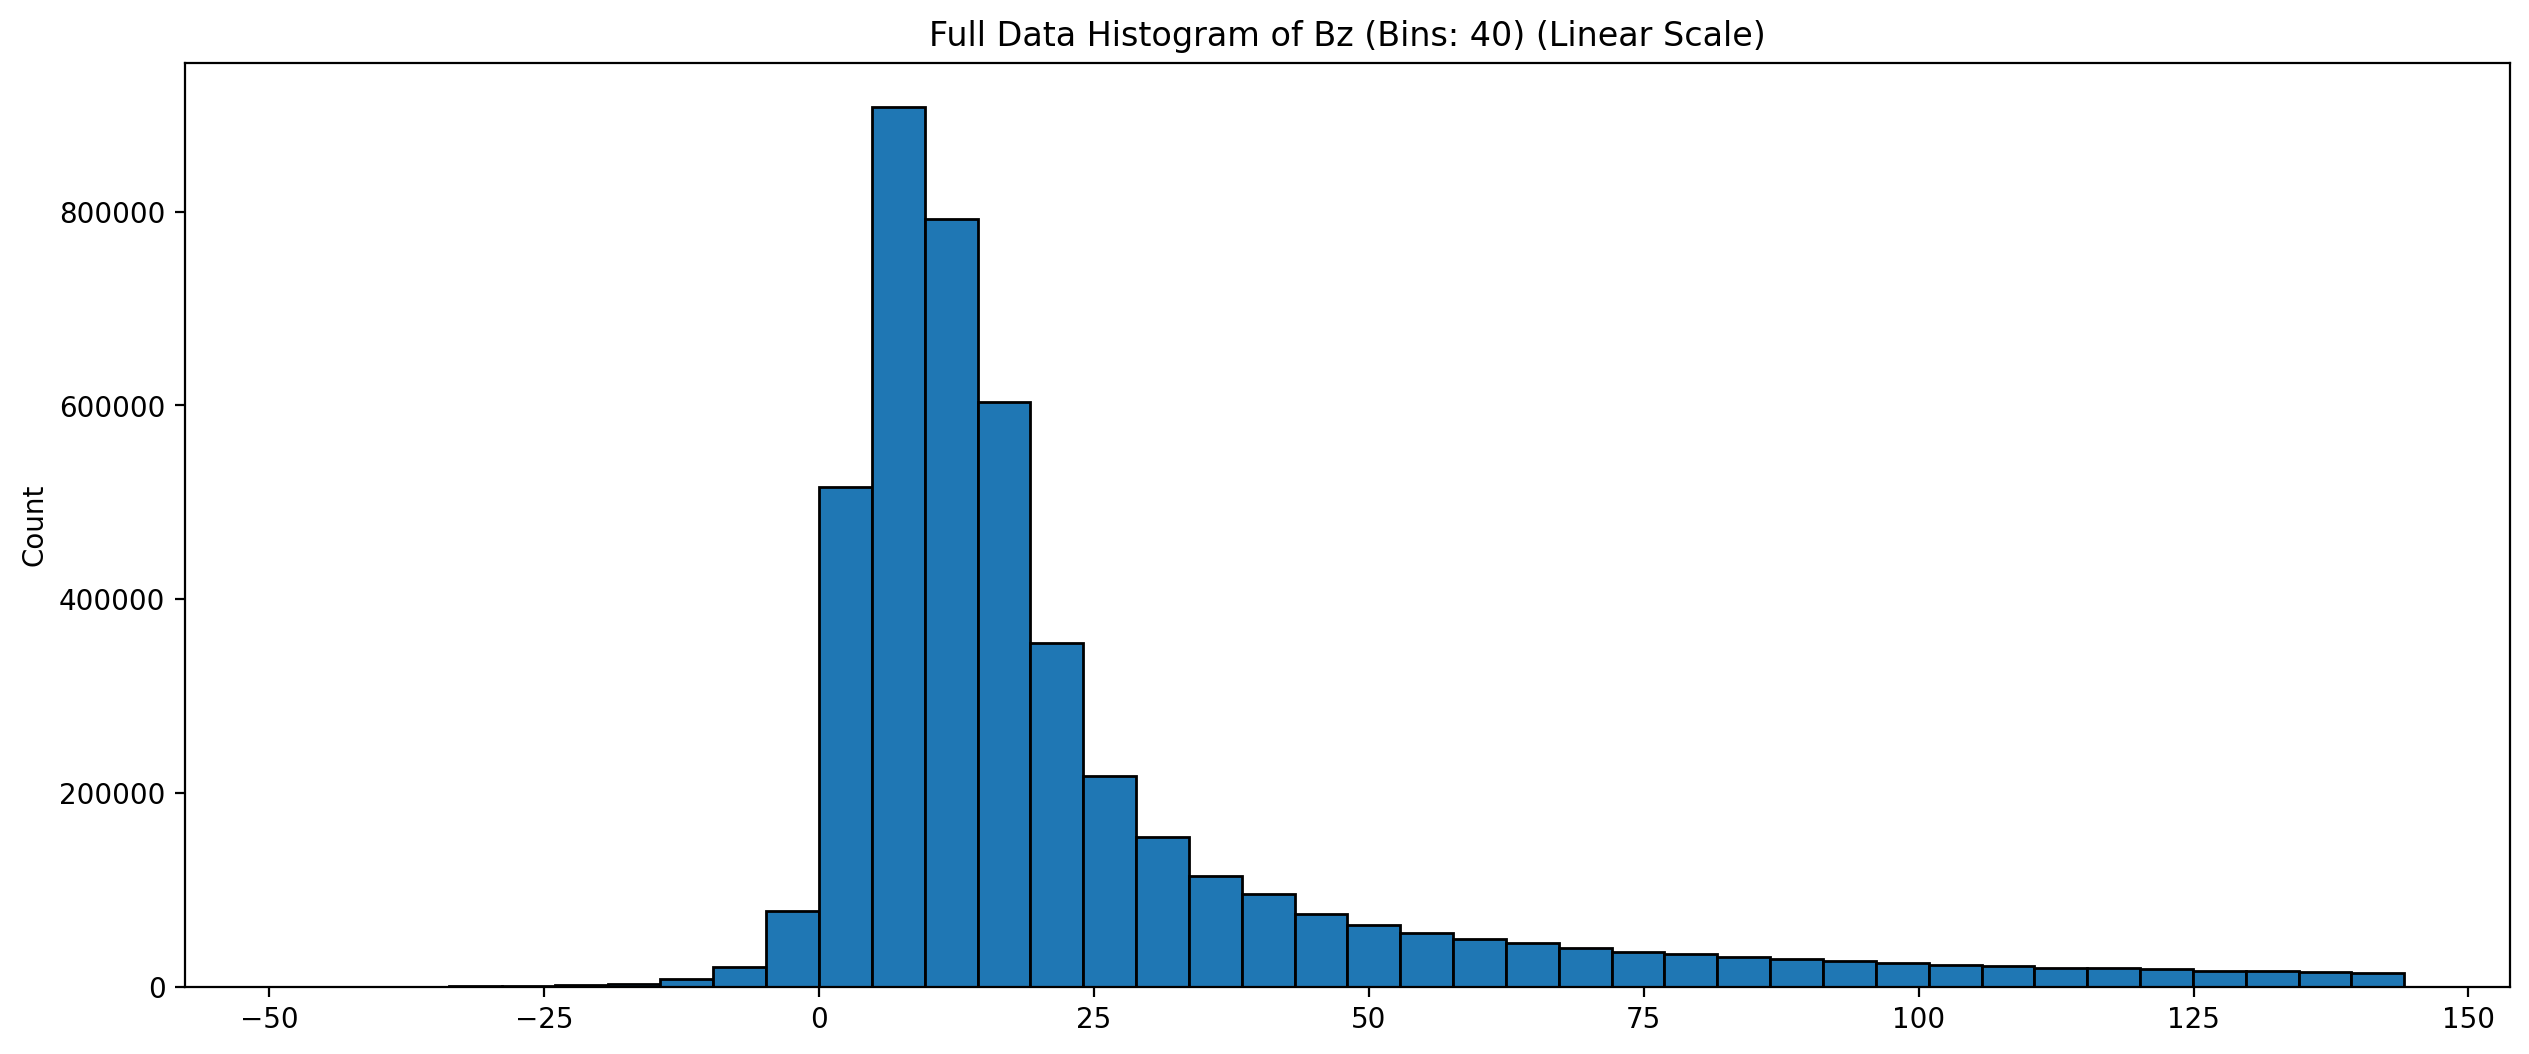

In [ ]:
plot_histogram(final_matrix, 'Bz', bins=60, log_scale=False, filter_column='Bz', remove_outliers=True)

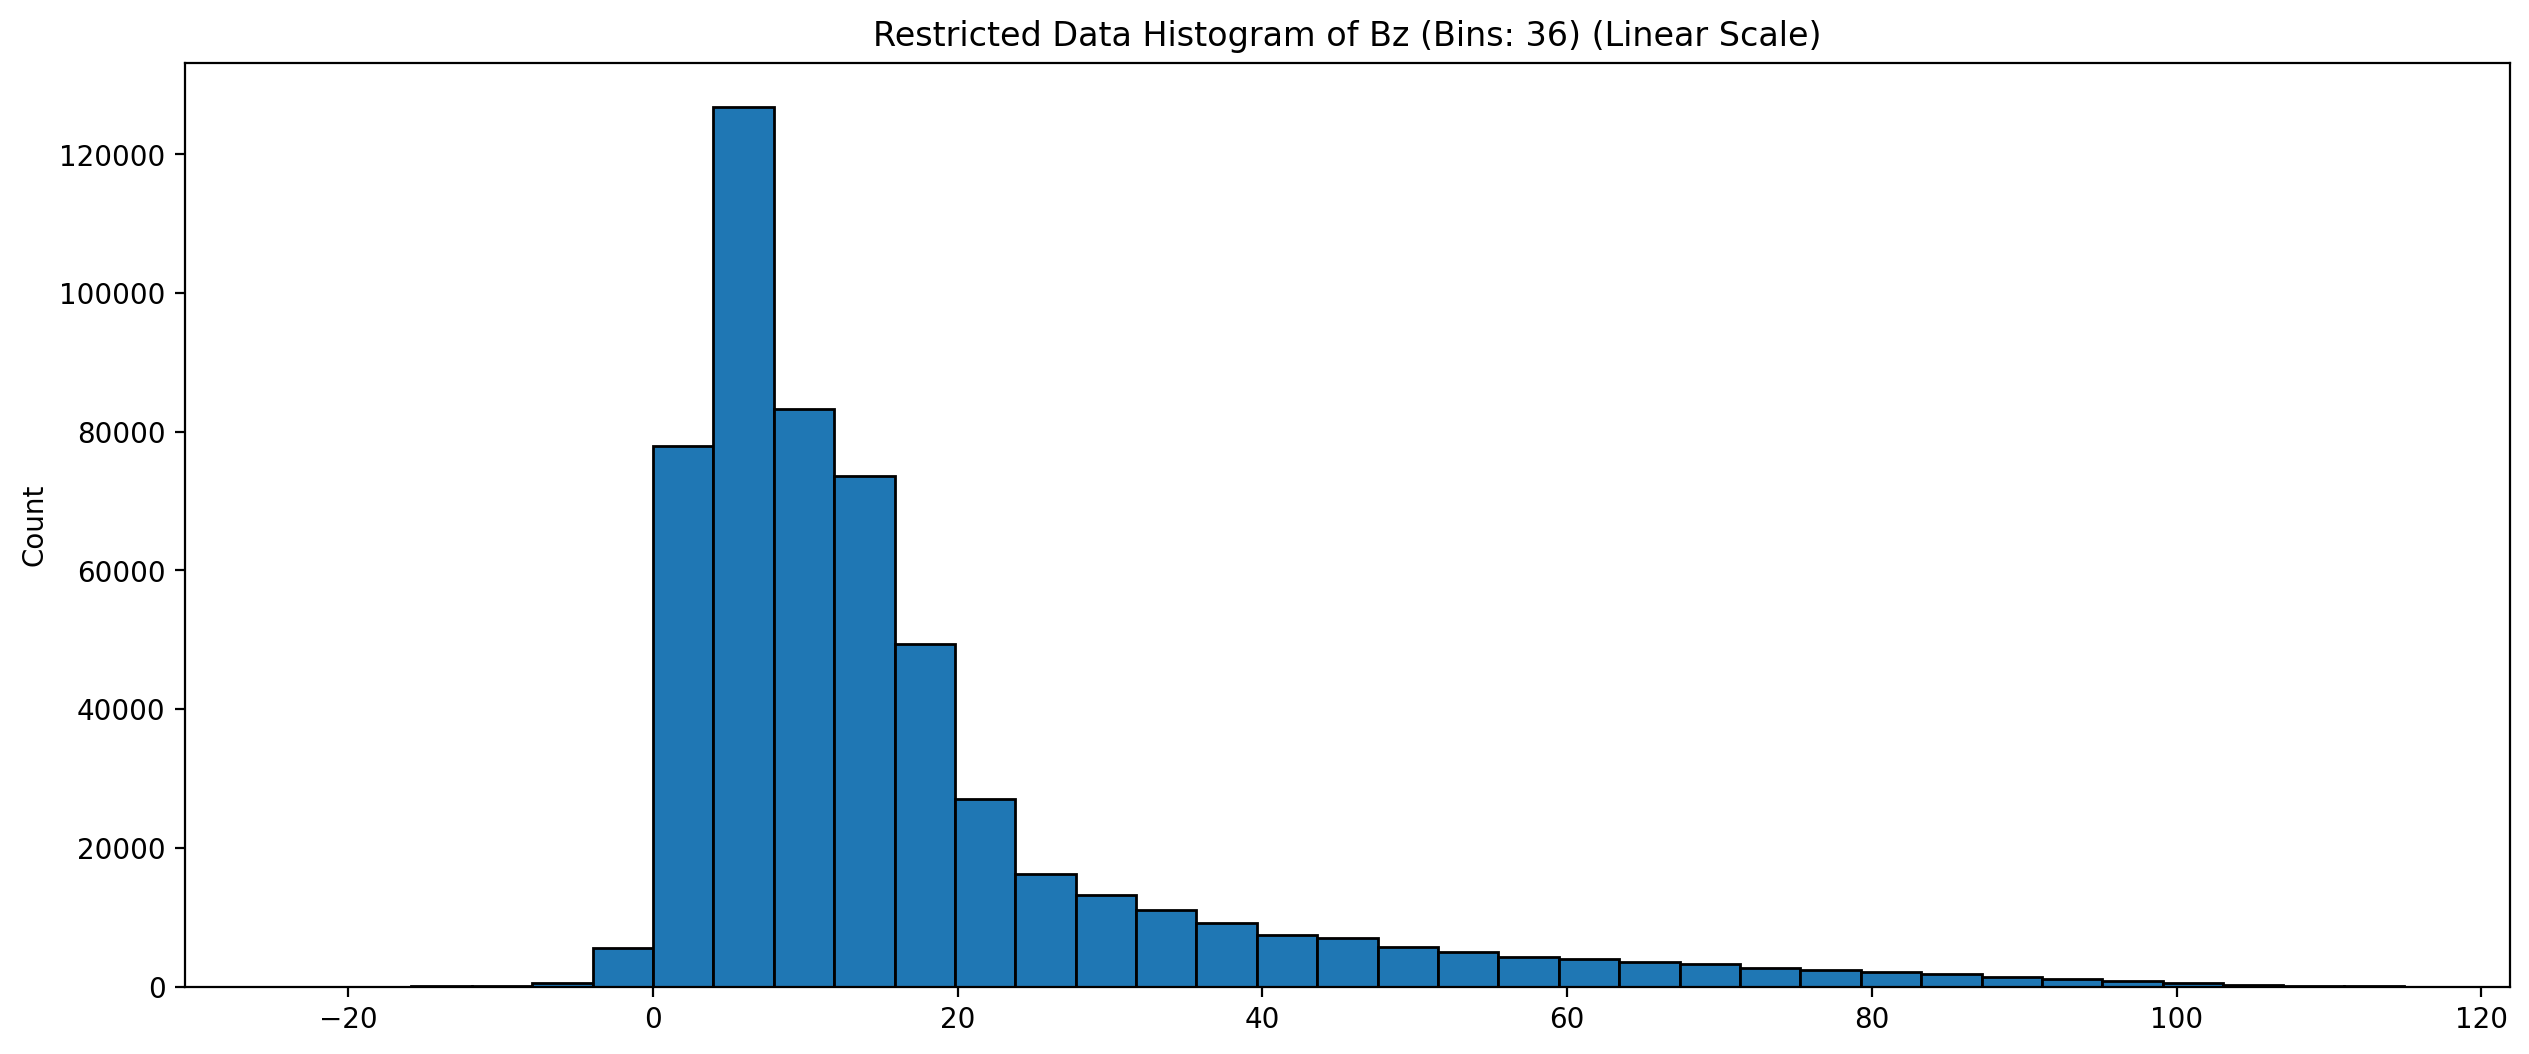

In [ ]:
plot_histogram(restricted_set, 'Bz', bins=60, log_scale=False, filter_column=None, remove_outliers=False, restricted=True)

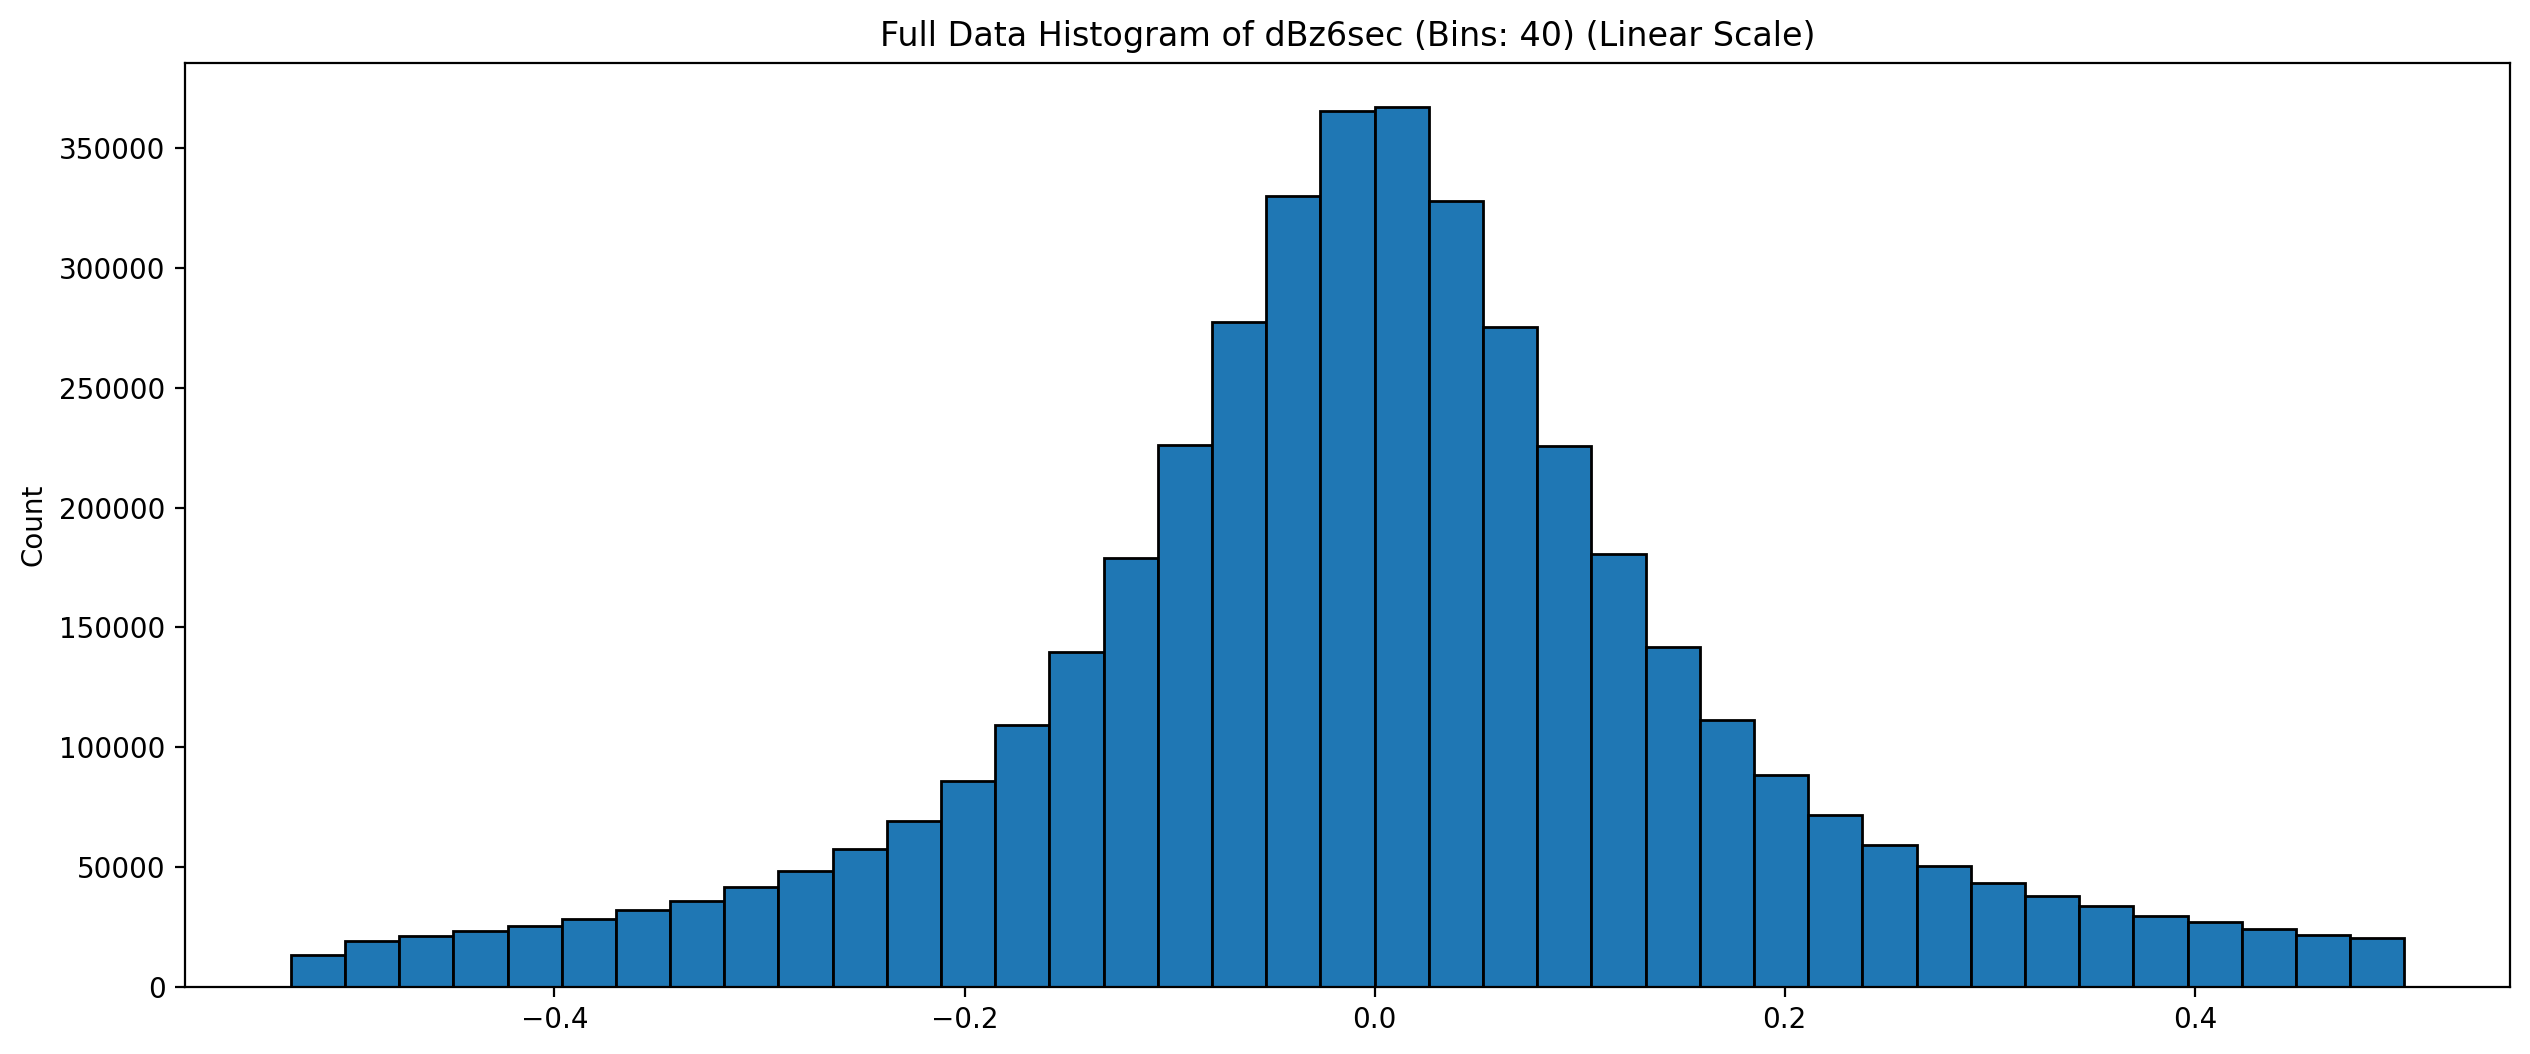

In [ ]:
plot_histogram(final_matrix, 'dBz6sec', filter_column='dBz6sec', bins=40, log_scale=False)

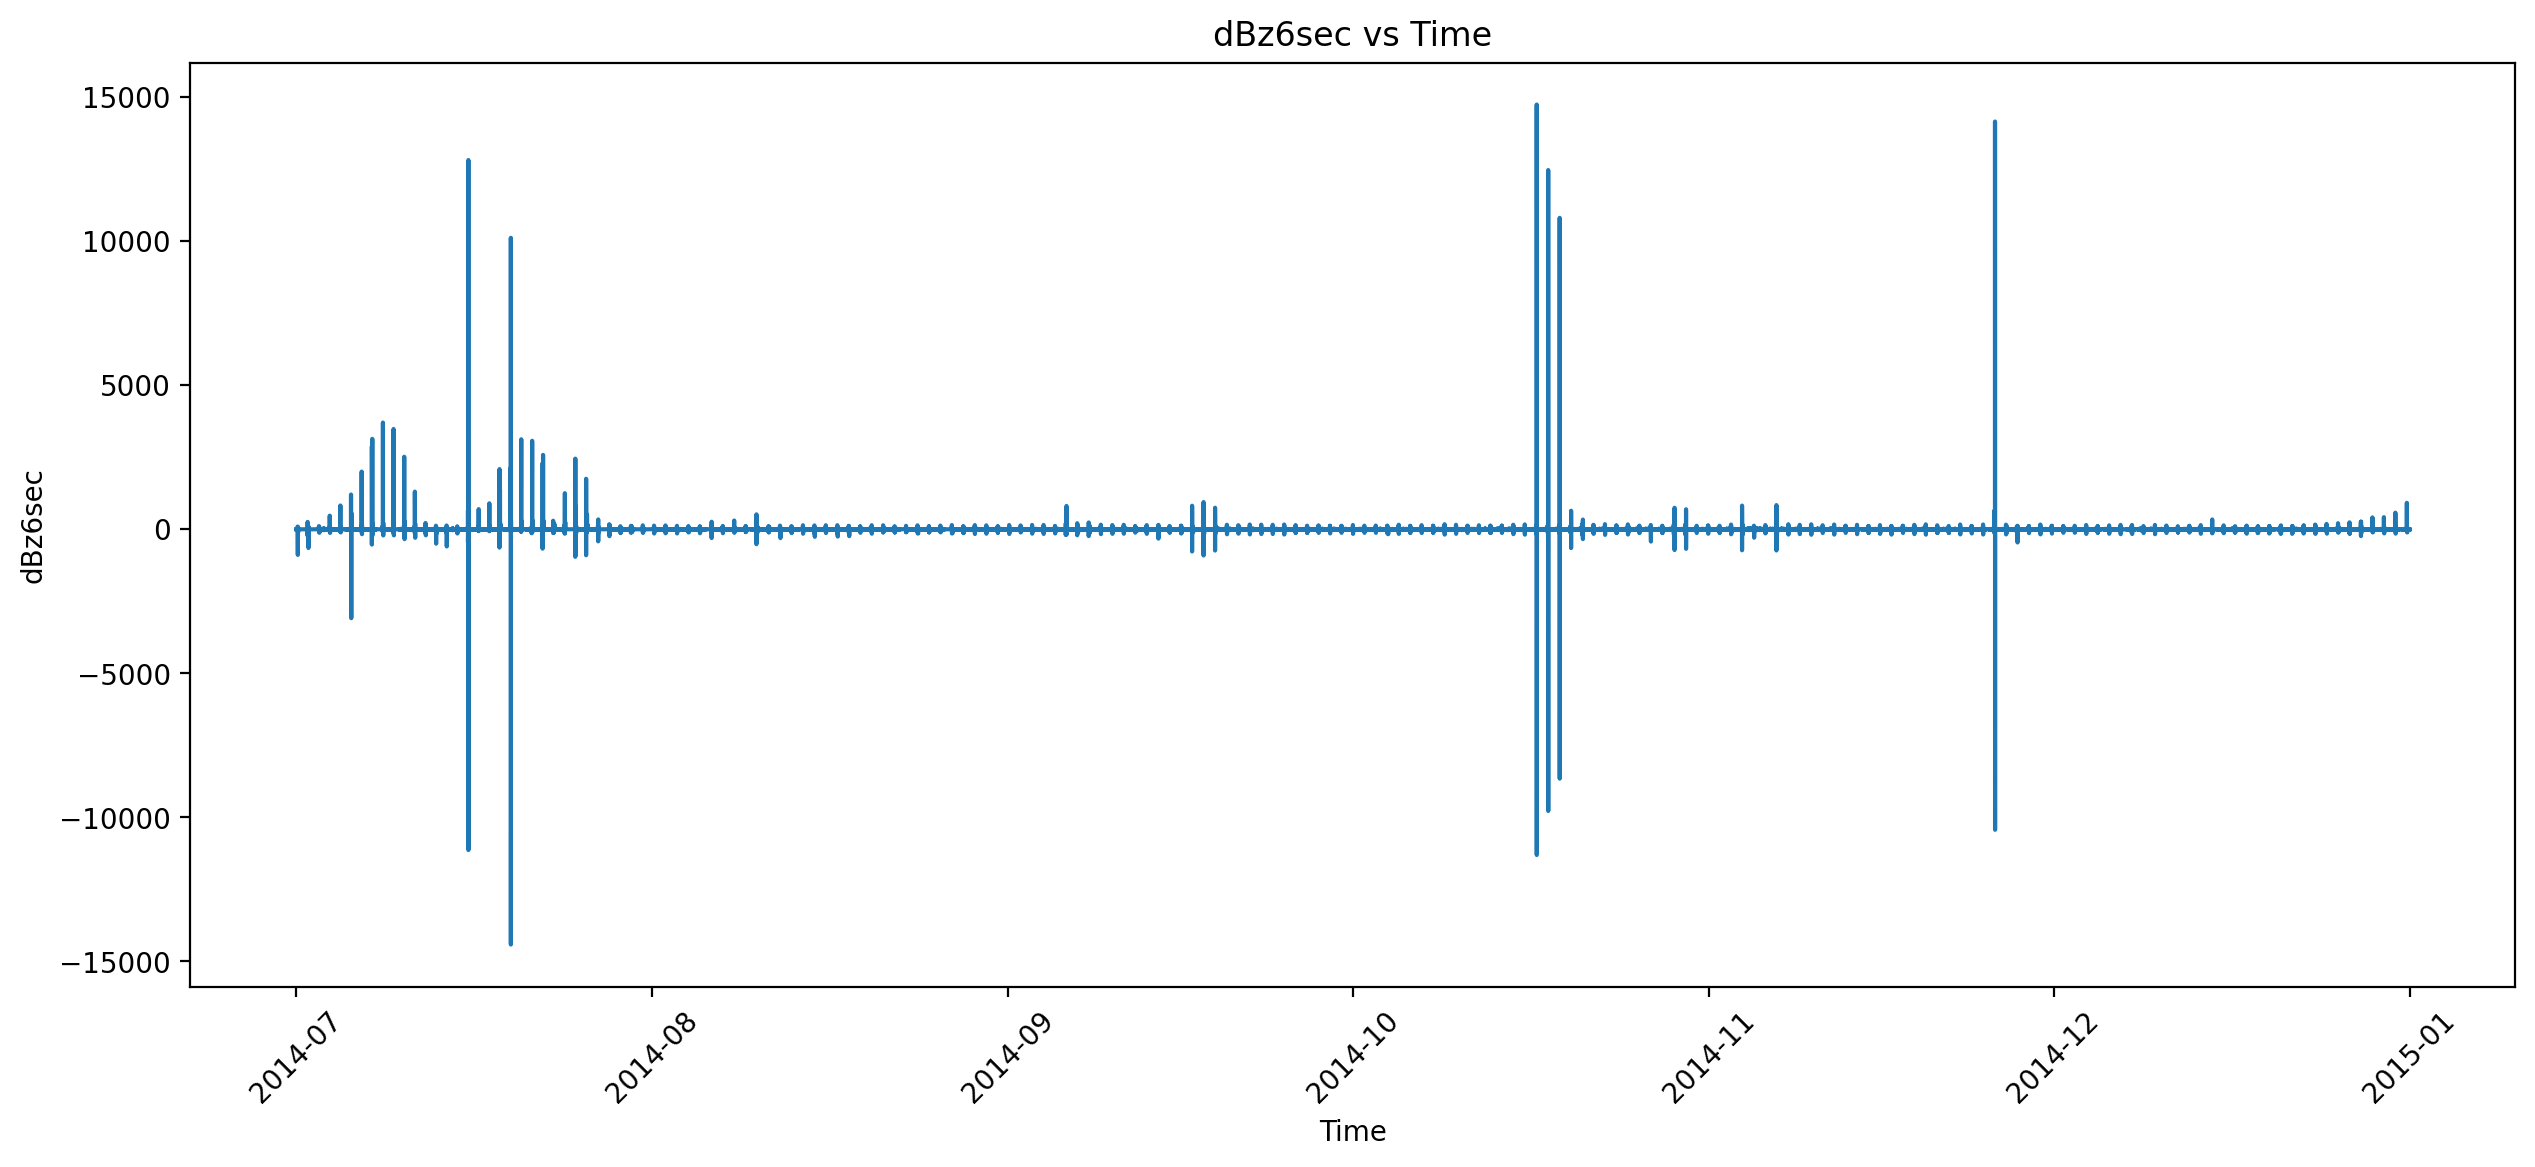

In [ ]:
plot_time_series(final_matrix, 'dBz6sec', filter_column='dBz6sec', remove_outliers=False)

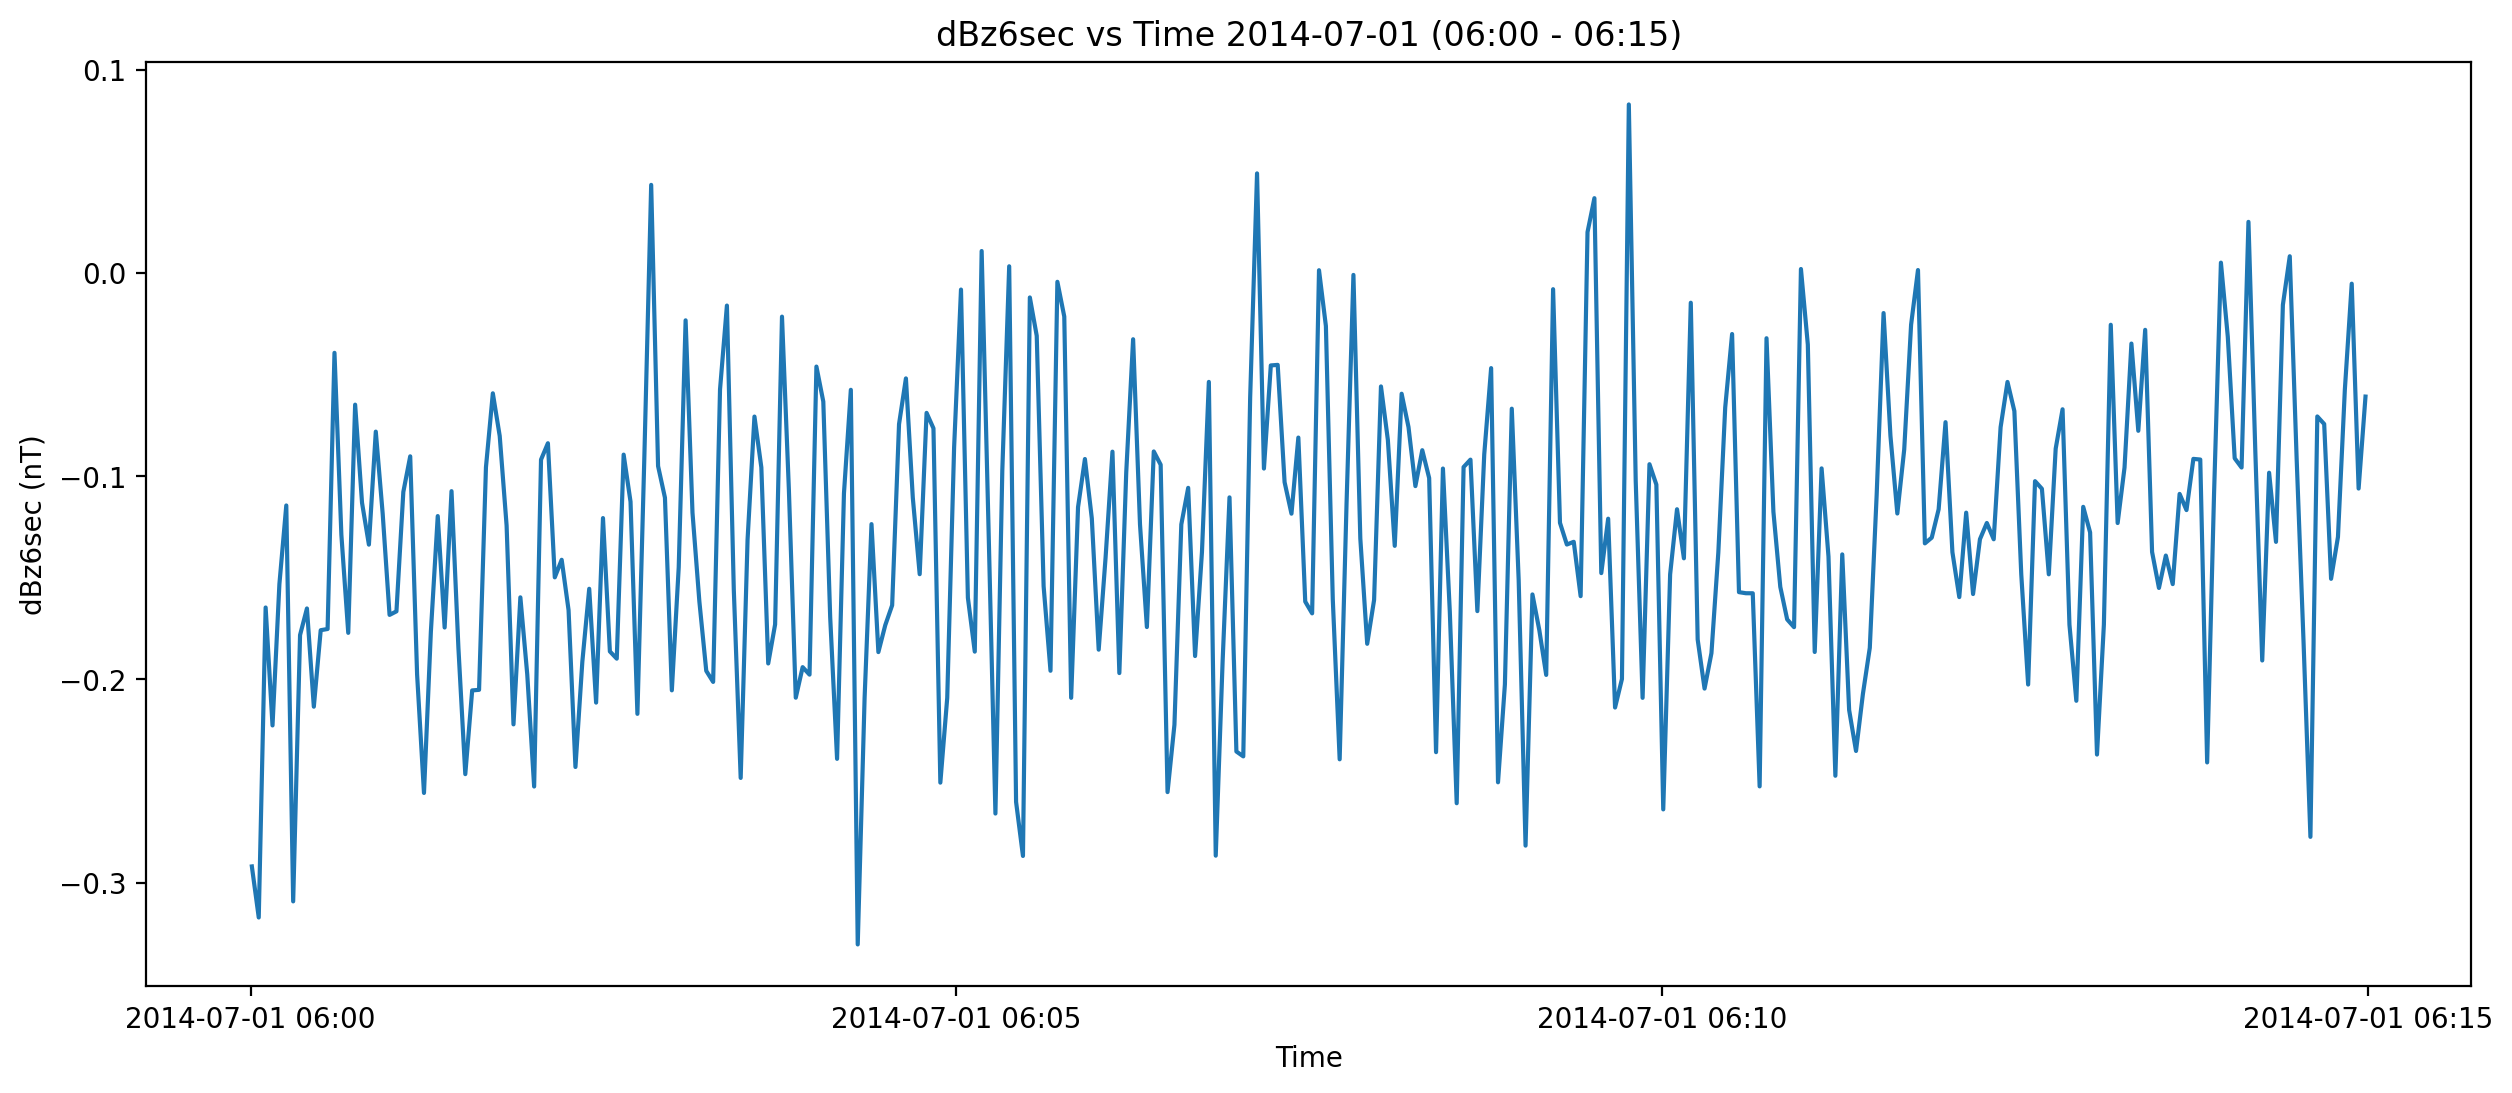

In [22]:
specific_day = '2014-07-01'

mask = final_matrix['Time'].dt.date == pd.to_datetime(specific_day).date()
filtered_data = final_matrix[mask]

start_time = pd.to_datetime(f'{specific_day} 06:00:00', utc=True)
end_time = start_time + pd.Timedelta(hours=0.25)

mask_9_hours = (filtered_data['Time'] >= start_time) & (filtered_data['Time'] <= end_time)
filtered_data_9_hours = filtered_data[mask_9_hours]

plt.figure(figsize=(15, 6), dpi=200)
plt.plot(filtered_data_9_hours['Time'], filtered_data_9_hours['dBz6sec'])
plt.xlabel('Time')
plt.ylabel('dBz6sec (nT)')
plt.tick_params(axis='y')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.title(f'dBz6sec vs Time {specific_day} (06:00 - 06:15)')
plt.show()

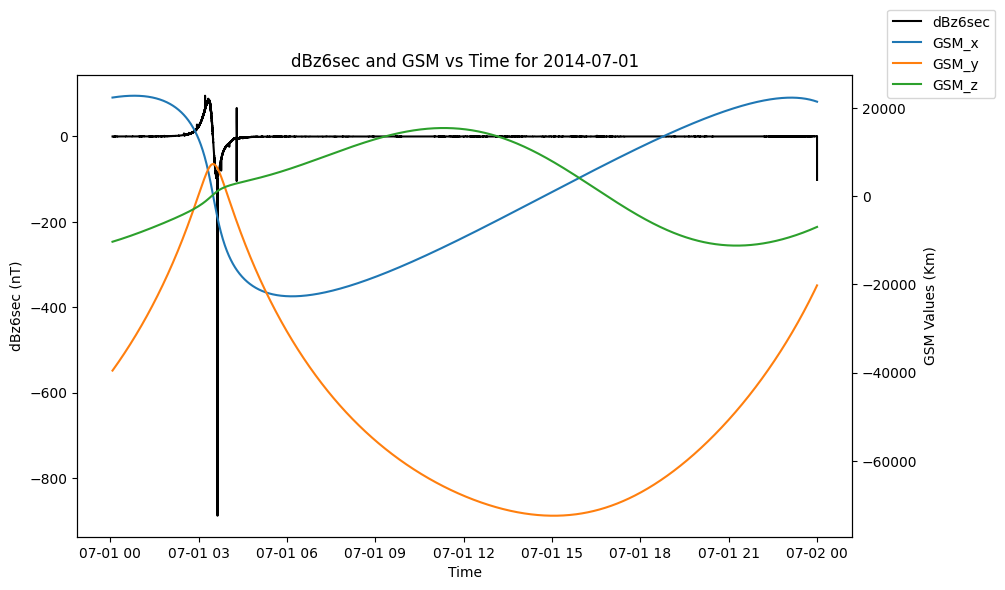

In [23]:
specific_day = '2014-07-01'

mask = final_matrix['Time'].dt.date == pd.to_datetime(specific_day).date()
filtered_data = final_matrix[mask]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(filtered_data['Time'], filtered_data['dBz6sec'], color='black', label='dBz6sec')
ax1.set_xlabel('Time')
ax1.set_ylabel('dBz6sec (nT)')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.plot(filtered_data['Time'], filtered_data['GSM_x'], label='GSM_x')
ax2.plot(filtered_data['Time'], filtered_data['GSM_y'], label='GSM_y')
ax2.plot(filtered_data['Time'], filtered_data['GSM_z'], label='GSM_z')
ax2.set_ylabel('GSM Values (Km)', color='k')
ax2.tick_params(axis='y', labelcolor='k')

fig.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
plt.title(f'dBz6sec and GSM vs Time for {specific_day}')
plt.show()